In [1]:
import tmap as tm
import pandas as pd
from rdkit.Chem import AllChem as Chem
from mhfp.encoder import MHFPEncoder
from faerun import Faerun
from math import log

In [2]:
df = pd.read_csv("./CYPsDB.csv")
df.columns

Index(['protein', 'name', 'reaction', 'rheaID', 'substrates',
       'Substrate CHEBI ID', 'Substrate SMILES', 'reducing_agent', 'cofactor',
       'products', 'Product CHEBI ID', 'Product SMILES', 'organism_name',
       'kingdom_name', 'superkingdom_name', 'sequence', 'length',
       'additional info'],
      dtype='object')

In [3]:
def agg_kingdom_names(names):
    # return ', '.join(sorted(list(set(n))))
    return list(names)

def short_kingdom_names(names):
    if 'Plantae' in names:
        if 'Animalia' in names:
            return 'Plantae and Animalia'
        else:
            return 'Plantae'
    elif 'Animalia' in names:
        return 'Animalia'
    elif 'Fungi' in names:
        return 'Fungi'
    elif 'Bacteria' in names:
        return 'Bacteria'
    else:
        return 'Mixed'

df = df.dropna(subset=['Substrate SMILES'])
df['Substrate SMILES'] = df['Substrate SMILES'].apply(lambda s: s.split(';'))
df = df.explode('Substrate SMILES')
print(len(df))
# df = df.drop_duplicates(subset=['Substrate SMILES'])
df = df.groupby(by='Substrate SMILES').agg({'kingdom_name': agg_kingdom_names})
df = df.reset_index()
print(len(df))
df['short_kingdom_name'] = df['kingdom_name'].apply(short_kingdom_names)
df['num_substrate_occurences'] = df['kingdom_name'].apply(lambda n: log(len(n)))
# 
# df['num_substrate_occurences'] = df['kingdom_name'].apply(len)
df

2929
456


,Substrate SMILES,kingdom_name,short_kingdom_name,num_substrate_occurences
0,*[H],"[Animalia, Animalia, Bacteria, Bacteria, Anima...",Plantae and Animalia,5.361292
1,C(*C([O-])=O)C,[Fungi],Fungi,0.000000
2,C(=C/C(=C/CC[C@H](C)C/C=C/C=C\C)/C)\C(=C/1\C([...,"[Fungi, Fungi, Fungi]",Fungi,1.098612
3,C(=C/C(C/C=C\CCCCC)O)\C=C/C/C=C\CCCC(=O)[O-],"[Animalia, Animalia]",Animalia,0.693147
4,C(CCCCCCCC(C(=O)[O-])O)CC,[Bacteria],Bacteria,0.000000
...,...,...,...,...
451,[O-]C(CCCCCCCCCCC(CCCCCC)O)=O,"[Animalia, Animalia]",Animalia,0.693147
452,[O-]C1=C(C(=O)C2=C(C)C=C(O)C=C2OC)C(=C(C(=C1)O...,[Fungi],Fungi,0.000000
453,[O-][N+]#N,"[Fungi, Fungi]",Fungi,0.693147
454,[O-]c1ccc(cc1)[N+]([O-])=O,"[Animalia, Animalia, Animalia, Animalia, Anima...",Animalia,2.302585


179 Plantae
149 Animalia

In [4]:
fp_size = 2048
enc = MHFPEncoder(fp_size)
def smi_to_mhfp(smi):
    try:
        return enc.encode_mol(Chem.MolFromSmiles(smi))
    except:
        return None
df['Substrate MHFP'] = df['Substrate SMILES'].apply(smi_to_mhfp)

[23:47:27] WARNING: not removing hydrogen atom with dummy atom neighbors
/root/anaconda3/envs/tmap_env/lib/python3.9/site-packages/mhfp/encoder.py:297: UserWarning: The length of the shingling is 0, which results in an empty set and an all zero folded fingerprint.
  warnings.warn("The length of the shingling is 0, which results in an empty set and an all zero folded fingerprint.")


In [5]:
df['Substrate MHFP'] = df['Substrate MHFP'].apply(tm.VectorUint)
df = df.dropna(subset=['Substrate MHFP']).reset_index(drop=True)

In [12]:
l = 1024

lf = tm.LSHForest(fp_size, l)
lf.batch_add(df['Substrate MHFP'])
lf.index()

cfg = tm.LayoutConfiguration()
cfg.node_size = 1 / 26
cfg.mmm_repeats = 2
cfg.sl_extra_scaling_steps = 5
cfg.k = 20
cfg.sl_scaling_type = tm.RelativeToAvgLength
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

db_kingdom_labels, db_kingdom_data = Faerun.create_categories(df['short_kingdom_name'])

f = Faerun(clear_color='#FFFFFF',view="front", coords=False)
f.add_scatter(
    "kingdom_name",
    {
        "x": x,
        "y": y,
        "c": [db_kingdom_data, df['num_substrate_occurences']],
        "labels": df['Substrate SMILES']
    },
    shader="smoothCircle",
    point_scale=10.0,
    max_point_size=400,
    legend_labels=[db_kingdom_labels, None],
    categorical=[True, False],
    colormap=["tab20", 'viridis'],
    series_title=["Kingdom name", "Num. of occurences"],
    has_legend=[True, False],
)

out_html_name = 'tmap_v2'
f.add_tree("small_mols_tree", {"from": s, "to": t}, point_helper="kingdom_name")
f.plot(template='smiles', file_name=out_html_name, path='tmaps')

/root/baka/BcProject/tmaps/tmap_v2.html

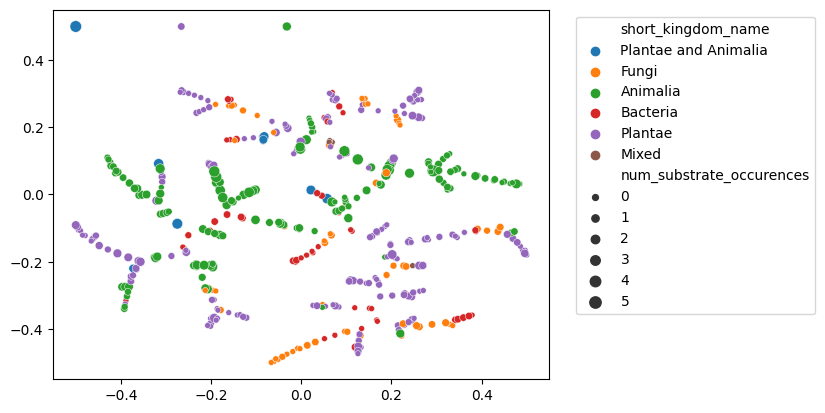

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(x=x, y=y, hue=df['short_kingdom_name'], size=df['num_substrate_occurences'])
plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1))